In [64]:
# Importing all necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Section A: Understanding the Dataset

### What does this dataset represent?
This dataset represents simulated historical project data designed to mirror real-world project management scenarios. Each row corresponds to a single project, while the columns capture key project attributes such as budget, team size, complexity, methodology, organizational maturity, and external influences. The target variable **Risk_Level** classifies projects into four categories: *Critical, High, Medium,* and *Low*, framing the task as a multi-class classification problem.

### Why is this dataset suitable for project risk prediction?
The dataset combines numerical and categorical features that are commonly used in professional project risk assessments. These variables collectively reflect technical, organizational, and human dimensions of project execution, making the dataset suitable for building and evaluating predictive risk models.

In [65]:
# Loading the dataset
df = pd.read_csv("../data/raw_data/project_risk_raw_dataset.csv")

print("Original shape:", df.shape)

# Drop column with many missing values
if "Tech_Environment_Stability" in df.columns:
    df = df.drop(columns=["Tech_Environment_Stability"])

# Fill important missing categorical values
for col in ["Change_Control_Maturity", "Risk_Management_Maturity"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

print("After cleaning:", df.shape)

df.head()

Original shape: (4000, 51)
After cleaning: (4000, 50)


,Project_ID,Project_Type,Team_Size,Project_Budget_USD,Estimated_Timeline_Months,Complexity_Score,Stakeholder_Count,Methodology_Used,Team_Experience_Level,Past_Similar_Projects,...,Industry_Volatility,Client_Experience_Level,Change_Control_Maturity,Risk_Management_Maturity,Team_Colocation,Documentation_Quality,Project_Start_Month,Current_Phase_Duration_Months,Seasonal_Risk_Factor,Risk_Level
0,PROJ_0001,Construction,32,1526276.55,32,9.70,16,Waterfall,Senior,3,...,Extreme,First-time,Basic,Basic,Fully Colocated,Good,10,5,1.0,High
1,PROJ_0002,Manufacturing,2,390790.15,9,2.72,9,Kanban,Mixed,0,...,Stable,Occasional,Advanced,Formal,Fully Remote,Poor,9,3,1.0,Low
2,PROJ_0003,Manufacturing,2,246674.76,6,2.04,7,Agile,Mixed,1,...,Stable,Regular,Unknown,Unknown,Hybrid,Good,5,1,1.0,Medium
3,PROJ_0004,IT,12,1427830.63,17,7.54,16,Scrum,Mixed,0,...,Extreme,Strategic,Formal,Basic,Hybrid,Basic,12,6,1.1,High
4,PROJ_0005,Construction,24,1696746.64,24,6.68,17,Hybrid,Junior,0,...,Moderate,Occasional,Basic,Unknown,Partially Colocated,Basic,9,6,1.0,High


## Section B: Exploratory Data Analysis (EDA)

### What does the distribution of Team Size indicate?
The distribution of **Team_Size** is right-skewed, indicating that most projects operate with small to medium-sized teams, while a limited number involve large teams. Larger teams often introduce coordination complexity, which may increase project risk.

### Why are there outliers in Team Size and Project Budget?
Outliers represent large-scale or enterprise-level projects rather than data errors. Since such projects are realistic and relevant for risk analysis, these observations were retained to preserve real-world variability.

### What does the distribution of Risk Levels tell us?
The dataset contains a higher proportion of *Medium* risk projects, followed by *High*, *Low*, and *Critical*. This mild class imbalance reflects real-world project portfolios and justifies the use of stratified sampling during model training.

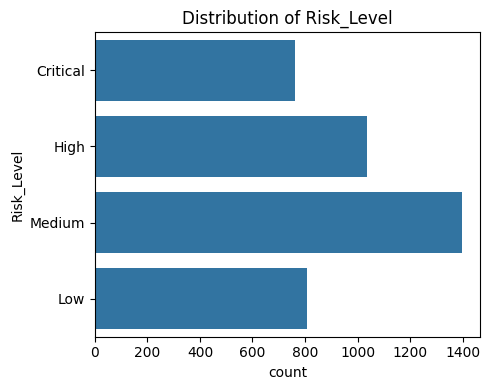

Risk_Level
Medium      1396
High        1036
Low          806
Critical     762
Name: count, dtype: int64

Numeric columns: ['Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Past_Similar_Projects', 'External_Dependencies_Count', 'Change_Request_Frequency', 'Team_Turnover_Rate', 'Vendor_Reliability_Score', 'Historical_Risk_Incidents', 'Communication_Frequency', 'Geographical_Distribution', 'Schedule_Pressure', 'Budget_Utilization_Rate', 'Market_Volatility', 'Integration_Complexity', 'Resource_Availability', 'Organizational_Change_Frequency', 'Cross_Functional_Dependencies', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Project_Start_Month', 'Current_Phase_Duration_Months', 'Seasonal_Risk_Factor']


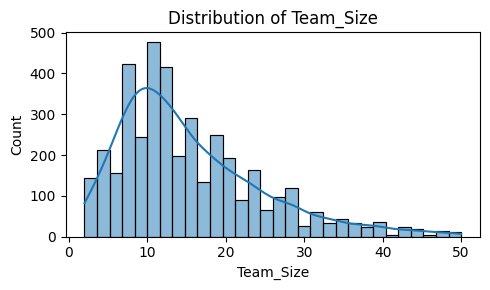

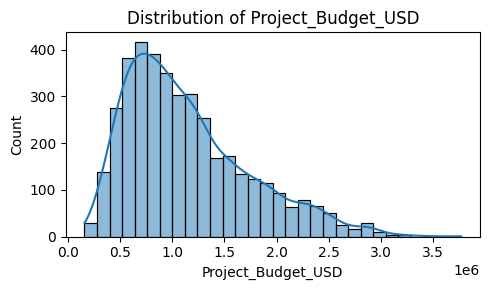

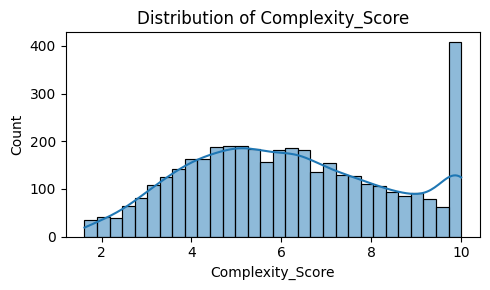

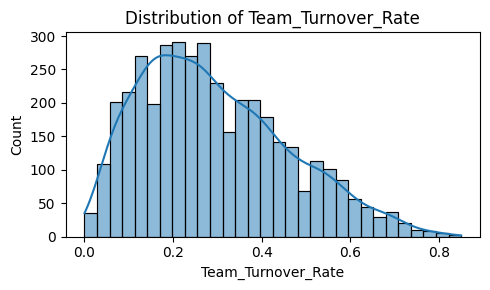

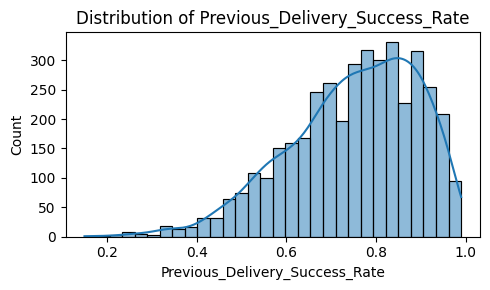

In [66]:
# Performing Basic EDA – Risk level distribution and a few numeric features

# 1) Risk level distribution
plt.figure(figsize=(5, 4))
sns.countplot(y="Risk_Level", data=df, order=["Critical", "High", "Medium", "Low"])
plt.title("Distribution of Risk_Level")
plt.tight_layout()
plt.show()

print(df["Risk_Level"].value_counts())

# 2) Example numeric histograms
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols_all)

example_numeric = ["Team_Size", "Project_Budget_USD", "Complexity_Score", 
                   "Team_Turnover_Rate", "Previous_Delivery_Success_Rate"]
example_numeric = [c for c in example_numeric if c in numeric_cols_all]

for col in example_numeric:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


## Section C: Train–Test Split Strategy

### Why was an 80–20 stratified split used?
An 80–20 split provides sufficient data for model training while reserving unseen data for evaluation. Stratification ensures that all risk categories are proportionally represented in both training and testing sets, improving evaluation reliability.

In [67]:
# Define X, y and train/test split

# Drop Project ID column – not useful for prediction
if "Project_ID" in df.columns:
    df_model = df.drop(columns=["Project_ID"])
else:
    df_model = df.copy()

X = df_model.drop(columns=["Risk_Level"])
y = df_model["Risk_Level"]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Number of numeric features:", len(numeric_cols))
print("Number of categorical features:", len(categorical_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Number of numeric features: 25
Number of categorical features: 23
Train size: (3200, 48) Test size: (800, 48)


## Section D: Data Preprocessing

### Why were numerical and categorical features treated differently?
Machine learning models require numerical input. Numerical variables were standardized to ensure comparable scales, while categorical variables were encoded to convert qualitative information into a usable numerical format.

### Why was One-Hot Encoding selected?
One-Hot Encoding prevents the model from assuming an artificial order among categorical values (e.g., Agile vs. Waterfall), which is particularly important for linear models such as Logistic Regression.

In [68]:
# Preprocessor – scale numeric, one-hot encode for categorical columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)


## Section E: Model Selection

### Why is this a classification problem?
The target variable consists of discrete risk categories rather than continuous values. Therefore, classification algorithms are appropriate for predicting project risk levels.

### Why was Logistic Regression chosen?
Logistic Regression is interpretable, computationally efficient, and well-suited for structured tabular data. It serves as a strong baseline model for multi-class risk prediction.

### Why was Random Forest also evaluated?
Random Forest models can capture non-linear relationships and feature interactions. They are widely used in risk prediction tasks where complex dependencies may exist.

Logistic Regression accuracy on test set:

c:\Users\manju\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 0.72125

Classification report for Logistic Regression :
              precision    recall  f1-score   support

    Critical       0.79      0.67      0.73       153
        High       0.61      0.68      0.64       207
         Low       0.82      0.78      0.80       161
      Medium       0.72      0.75      0.73       279

    accuracy                           0.72       800
   macro avg       0.74      0.72      0.73       800
weighted avg       0.73      0.72      0.72       800



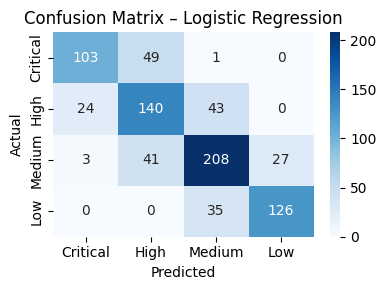

In [69]:
# Logistic Regression

log_reg_pipe = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, multi_class="multinomial")),
    ]
)

log_reg_pipe.fit(X_train, y_train)
y_pred_lr = log_reg_pipe.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression accuracy on test set:", acc_lr)

print("\nClassification report for Logistic Regression :")
print(classification_report(y_test, y_pred_lr))

labels_order = ["Critical", "High", "Medium", "Low"]
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels_order)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Section F: Model Evaluation

### What does accuracy mean in this context?
Accuracy represents the proportion of projects for which the predicted risk level matches the actual risk level. For example, a 72% accuracy indicates that the model correctly classified 72 out of 100 projects.

### Why are precision, recall, and F1-score important?
These metrics provide deeper insight into model performance across individual risk categories, particularly for *High* and *Critical* risks, which are most important from a business decision-making perspective.

Random Forest accuracy on test set: 0.55625

Classification report for Random Forest:
              precision    recall  f1-score   support

    Critical       0.69      0.56      0.62       153
        High       0.46      0.29      0.36       207
         Low       0.77      0.45      0.56       161
      Medium       0.50      0.81      0.62       279

    accuracy                           0.56       800
   macro avg       0.61      0.53      0.54       800
weighted avg       0.58      0.56      0.54       800



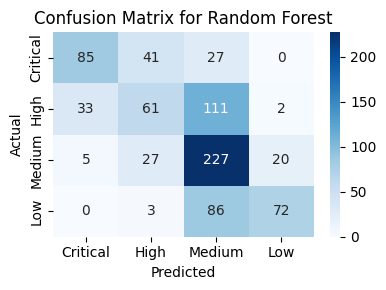

In [70]:
# Random Forest

rf_pipe = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            random_state=42,
            class_weight="balanced"
        )),
    ]
)

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy on test set:", acc_rf)

print("\nClassification report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels_order)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Hierarchical Random Forest accuracy on test set: 0.54875

Classification report for Hierarchical Random Forest:
              precision    recall  f1-score   support

    Critical       0.58      0.63      0.61       153
        High       0.45      0.40      0.42       207
         Low       0.81      0.38      0.52       161
      Medium       0.53      0.71      0.61       279

    accuracy                           0.55       800
   macro avg       0.59      0.53      0.54       800
weighted avg       0.58      0.55      0.54       800



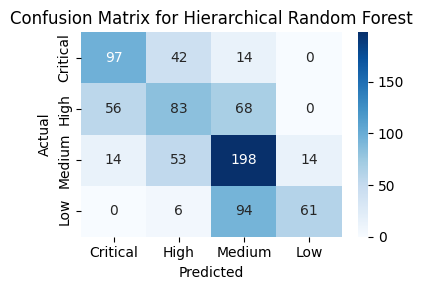

In [71]:
# Hierarchical Random Forest

# Stage 1: Predicting High-risk? (High or Critical = 1, Medium/Low = 0)
y_train_highflag = y_train.isin(["High", "Critical"]).astype(int)

rf_stage1 = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        )),
    ]
)
rf_stage1.fit(X_train, y_train_highflag)

# Stage 2 (For High branch): High vs Critical
mask_high = y_train.isin(["High", "Critical"])
X_train_high = X_train[mask_high]
y_train_high = y_train[mask_high].map({"High": 0, "Critical": 1})

rf_stage2_high = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        )),
    ]
)
rf_stage2_high.fit(X_train_high, y_train_high)

# Stage 2 (For Low branch): Low vs Medium
mask_low = y_train.isin(["Low", "Medium"])
X_train_low = X_train[mask_low]
y_train_low = y_train[mask_low].map({"Low": 0, "Medium": 1})

rf_stage2_low = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=42
        )),
    ]
)
rf_stage2_low.fit(X_train_low, y_train_low)


# Function to predict hierarchically on a DataFrame
def hier_predict(X_rows: pd.DataFrame) -> np.ndarray:
    preds = []
    for i in range(len(X_rows)):
        x_row = X_rows.iloc[i:i+1]

        # Stage 1: high-risk or not?
        stage1 = rf_stage1.predict(x_row)[0]

        if stage1 == 1:
            # go to High/Critical branch
            lab = rf_stage2_high.predict(x_row)[0]
            preds.append("High" if lab == 0 else "Critical")
        else:
            # go to Medium/Low branch
            lab = rf_stage2_low.predict(x_row)[0]
            preds.append("Low" if lab == 0 else "Medium")
    return np.array(preds)


# Evaluate hierarchical model
y_pred_hier = hier_predict(X_test)

acc_hier = accuracy_score(y_test, y_pred_hier)
print("Hierarchical Random Forest accuracy on test set:", acc_hier)

print("\nClassification report for Hierarchical Random Forest:")
print(classification_report(y_test, y_pred_hier))

cm_hier = confusion_matrix(y_test, y_pred_hier, labels=labels_order)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_hier, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix for Hierarchical Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [72]:
# Quick comparison of model accuracies

print("Logistic Regression accuracy:", round(acc_lr, 3))
print("Random Forest accuracy:", round(acc_rf, 3))
print("Hierarchical Random Forest accuracy:", round(acc_hier, 3))


Logistic Regression accuracy: 0.721
Random Forest accuracy: 0.556
Hierarchical Random Forest accuracy: 0.549


## Section G: Model Comparison and Interpretation

### Why did Logistic Regression outperform Random Forest?
The dataset exhibits relatively linear relationships between features and risk levels. Logistic Regression benefits from this structure and avoids overfitting, whereas Random Forest performance may be limited by dataset size and high dimensionality after encoding.

### What is the business relevance of the selected model?
The final model provides early warning signals for high-risk projects, enabling project managers and PMOs to prioritize interventions, allocate experienced resources, and proactively mitigate cost and schedule overruns.

In [73]:
# Feature importance from Random Forest

# 1) Access the trained RF and the preprocessor from the pipeline
rf_model = rf_pipe.named_steps["clf"]
prep = rf_pipe.named_steps["prep"]

# 2) Get the names of the one-hot encoded categorical features
ohe = prep.named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))

# 3) Combine numeric + encoded categorical feature names
all_feature_names = numeric_cols + cat_feature_names

# 4) Build DataFrame of importances
importances = rf_model.feature_importances_
feat_imp = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

feat_imp.head(15)


,feature,importance
3,Complexity_Score,0.047232
8,Team_Turnover_Rate,0.031928
20,Previous_Delivery_Success_Rate,0.027763
2,Estimated_Timeline_Months,0.027015
15,Market_Volatility,0.025850
16,Integration_Complexity,0.025443
11,Communication_Frequency,0.025299
1,Project_Budget_USD,0.024694
18,Organizational_Change_Frequency,0.023895
17,Resource_Availability,0.023871


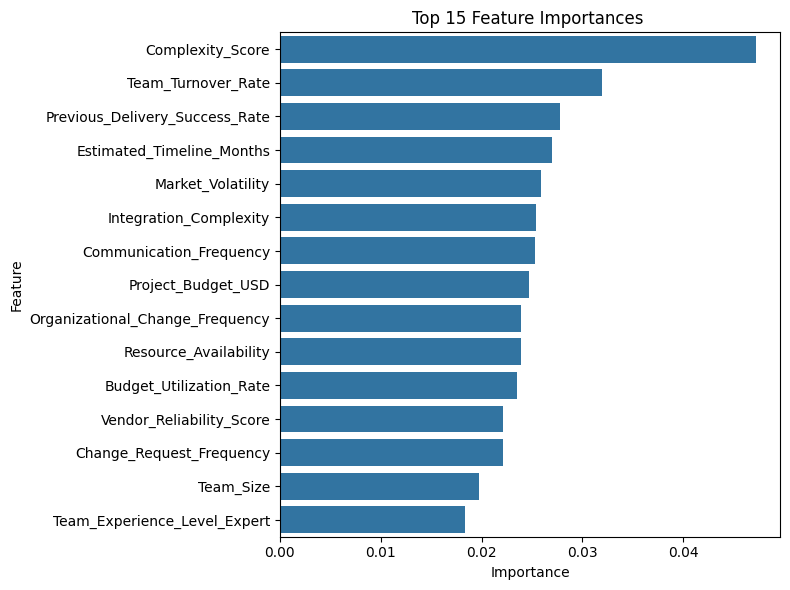

In [74]:
# Plotting top 15 important features

top15 = feat_imp.head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=top15, x="importance", y="feature")
plt.title("Top 15 Feature Importances ")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


The processed dataset refers to the cleaned and transformed version of the original data after handling categorical encoding, feature selection, and preparation for modeling

In [75]:
import os

# Define output directory and file path
output_dir = "../data/processed_data"
output_path = os.path.join(
    output_dir, 
    "processed_project_risk_raw_dataset.csv"
)

# Create directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Save the processed dataset
df_model.to_csv(output_path, index=False)

print(f"Processed dataset successfully saved at: {output_path}")


Processed dataset successfully saved at: ../data/processed_data\processed_project_risk_raw_dataset.csv


## Section H: Key Takeaway for the Notebook
The combination of clear preprocessing, interpretable modeling, and structured evaluation demonstrates how machine learning can support data-driven project risk management and complement traditional expert judgment.